<a href="https://colab.research.google.com/github/repairedserver/Test/blob/master/LSTM%EA%B3%BC_GRU2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [44]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [45]:
cd/content/gdrive/My Drive/deeplearningbro/deeplearningbro/pytorch

/content/gdrive/My Drive/deeplearningbro/deeplearningbro/pytorch


In [46]:
df = pd.read_csv("./data/kospi.csv")

In [47]:
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])

In [48]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [49]:
#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available')

cuda:0 is available


In [50]:
X = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

In [51]:
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x)-sequence_length):
    x_seq.append(x[i:i+sequence_length])
    y_seq.append(y[i+sequence_length])

  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1])

In [52]:
split = 200
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [53]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [54]:
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [55]:
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(GRU, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size*sequence_length, 1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.gru(x, h0) 
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [56]:
model = GRU(input_size=input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers=num_layers, device=device)

model = model.to(device)

In [57]:
criterion = nn.MSELoss()

lr=1e-3
num_epoch = 200
optimizer = optim.Adam(model.parameters(), lr=lr)

In [58]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epoch):
  running_loss = 0.0

  for data in train_loader:
    
    seq, target = data
    out = model(seq)
    loss = criterion(out, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 100 == 0:
    print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.6113
[epoch: 100] loss: 0.0009


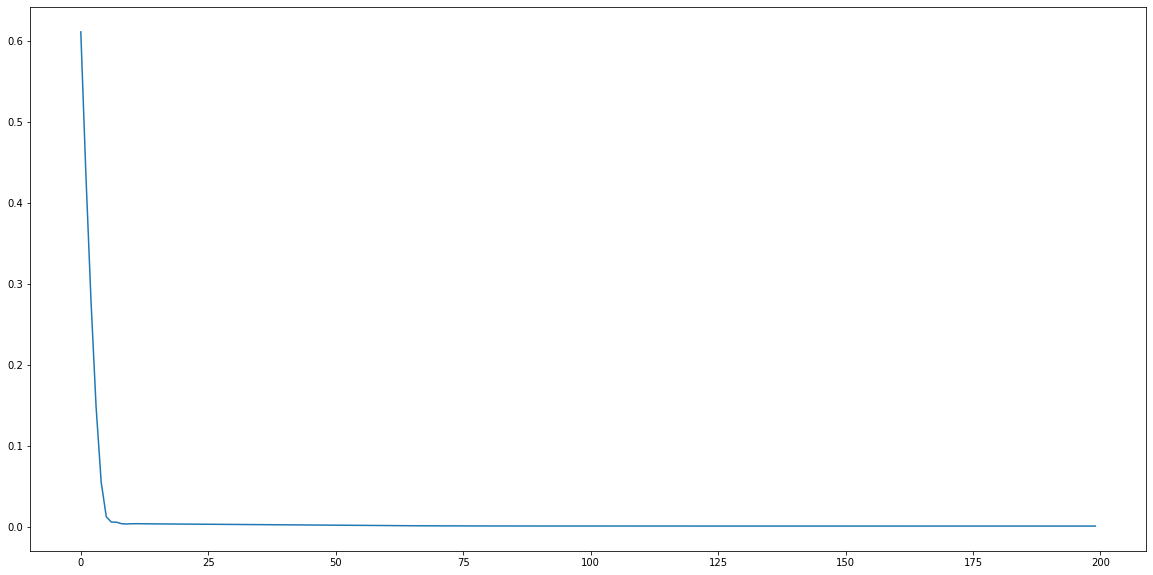

In [59]:
plt.figure(figsize=(20, 10))
plt.plot(loss_graph)
plt.show()

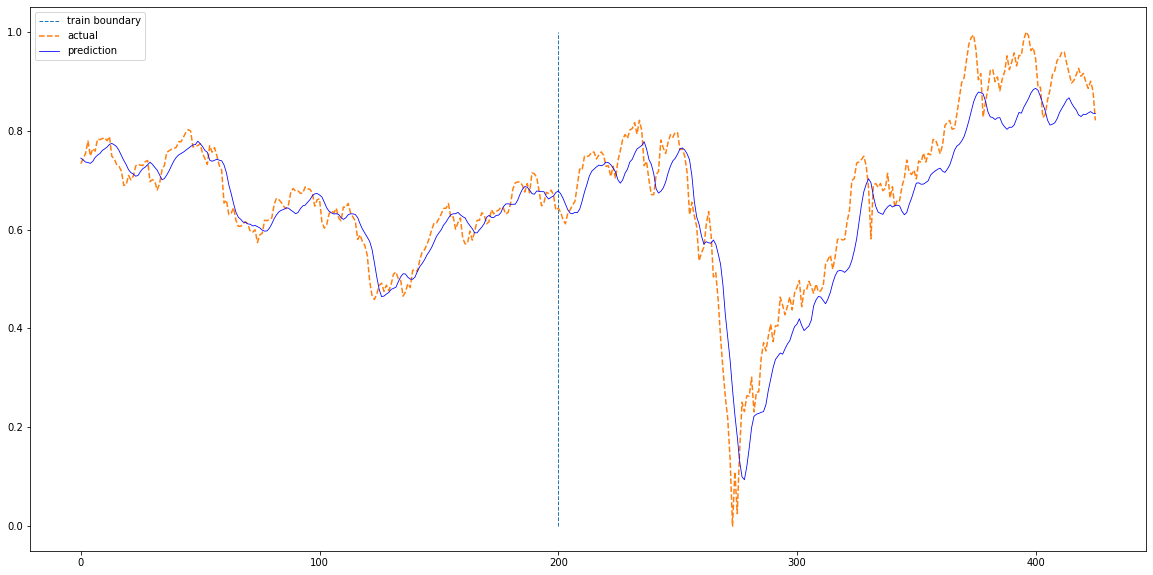

In [60]:
def plotting(train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()
    
    total = train_pred+test_pred
    plt.figure(figsize=(20,10))
    plt.plot(np.ones(100)*len(train_pred),np.linspace(0, 1, 100), '--', linewidth=1)
    plt.plot(actual,'--')
    plt.plot(total,'b',linewidth=0.8)

    plt.legend(['train boundary', 'actual', 'prediction'])
    plt.show()
  
plotting(train_loader, test_loader, df['Close'][sequence_length:].values)